First, call these scripts to download the genomes and prepare some taxonomic information:

/workdir/hdd29/theRefseqening/src/download_ncbi_data.py
/workdir/hdd29/theRefseqening/src/process_genome_mfas.py

/workdir/hdd29/theRefseqening/src/download_taxonomy_info.py

In [30]:
#Now, we need to keep only species level genomes. 
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import re 
from tqdm import tqdm
import seaborn as sns

(53181, 4)


Text(0, 0.5, 'Number of Genomes')

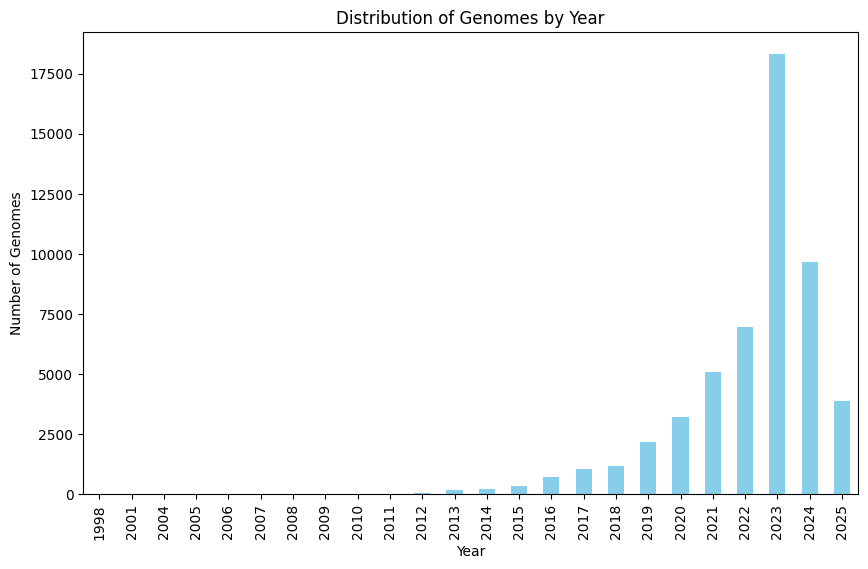

In [31]:
#read the taxonomy data, and plot the distribution of year 
tax = pd.read_csv('data/taxonomy_info.csv', index_col=0,header=0)
print(tax.shape)
#plot the distribution of year
plt.figure(figsize=(10, 6))
tax['Year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Genomes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Genomes')

19602


Text(0, 0.5, 'Frequency')

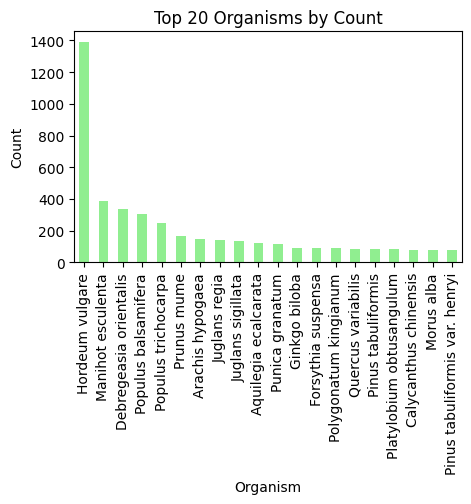

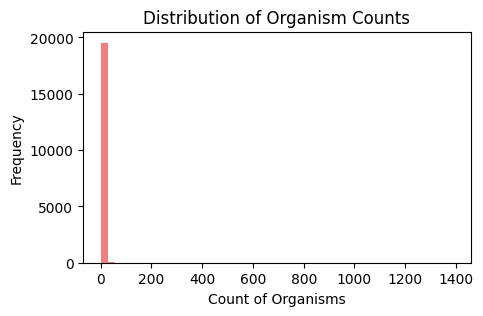

In [6]:
#how many unique Organism names are there?
print(tax['Organism'].nunique())

#what's the distribution of Organism counts?
plt.figure(figsize=(5, 3))
tax['Organism'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar', color='lightgreen')
plt.title('Top 20 Organisms by Count')
plt.xlabel('Organism')
plt.ylabel('Count')

#Plot the histogram of organism counts
plt.figure(figsize=(5, 3))
tax['Organism'].value_counts().plot(kind='hist', bins=50, color='lightcoral')
plt.title('Distribution of Organism Counts')
plt.xlabel('Count of Organisms')
plt.ylabel('Frequency')

In [32]:
genome_metadata = pd.read_csv('data/taxonomy_info.csv',header=0)

def clean_species_name(name):
    """
    Remove taxonomic qualifiers and return the first two valid words.
    """
    specifiers = {"x.", "sp.", "var.", "subsp.", "f.", "spp.", "cf.", "aff.", "ex"}
    words = name.split()
    cleaned_words = [w for w in words if w.lower().strip(".") not in specifiers]
    return " ".join(cleaned_words[:2]) if len(cleaned_words) >= 2 else " ".join(cleaned_words)

def get_lui_and_species(organism_name, accession_id):
    species = clean_species_name(organism_name)
    #take the first two words of the organism name
    org_short = "".join(organism_name.split()[:2])
    lui = f"{accession_id}_{org_short}"  # Remove space in LUI
    return lui, species

def alphanum_only(s):
    return re.sub(r'[^A-Za-z0-9]', '', s)

# Add LUI and species columns
genome_metadata["LUI"], genome_metadata["Species"] = zip(*genome_metadata.apply(
    lambda row: get_lui_and_species(row["Organism"], row["ID"]),
    axis=1
))
genome_metadata["LUI"] = genome_metadata["LUI"].apply(alphanum_only)
genome_metadata["Species"] = genome_metadata["Species"].apply(alphanum_only)

# how many unique species are there?
unique_species = genome_metadata['Species'].unique()
print(f"Number of unique species: {len(unique_species)}")

Number of unique species: 18605


In [3]:
#now, we will prepare the queries for the species occurence acquisition
# --- New code to generate args.txt ---
output_args_file = 'data/species_queries.txt' # Define the name for your arguments file
#iterate through each unique species and write the LUI and organism name to the file
unique_species = genome_metadata.drop_duplicates(subset=['Organism'])

with open(output_args_file, 'w') as f:
    for index, row in unique_species.iterrows():
        lui = row['LUI']
        organism_name = row['Organism']
        f.write(f"{lui} {organism_name}\n")
        

with open(output_args_file, 'r') as f:
    print("\nFirst 5 lines of species_queries.txt:")
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line.strip())


First 5 lines of species_queries.txt:
PV8908801Cyanotisnyctitropa Cyanotis nyctitropa
PV9487281Euonymuschloranthoides Euonymus chloranthoides
PV9629301Cardamineleucantha Cardamine leucantha
PQ6114591Polygonatumkingianum Polygonatum kingianum
PV1124521Taxussumatrana Taxus sumatrana


Run this in a protected tmux or screen session

parallel --bar --joblog parallel_jobs.log \
         --retry-failed \
         --delay 1 \
         --load 60% \
         --memfree 1G \
         --timeout 600 \
         --jobs 4 \
         ./run_occurrence_script.sh :::: data/species_queries.txt

In [3]:
#we will do something similar to prepare the whitelist fo kmer association 
output_args_file = 'data/unique_organism_luis.txt' # Define the name for your arguments file
#iterate through each unique species and write the LUI and organism name to the file
unique_species = genome_metadata.drop_duplicates(subset=['Organism'])

with open(output_args_file, 'w') as f:
    for index, row in unique_species.iterrows():
        lui = row['LUI']
        organism_name = row['Organism']
        f.write(f"{lui}\n")

In [ ]:
#now, we have a structure for the env_data output folder like
"""
env_data/
├── AB0861791Anthocerosangustus_Anthoceros_angustus
│   ├── Anthoceros_angustus_occurrences_clean.csv
│   ├── pirate_coords.csv
│   ├── species_metadata_bien
│   │   └── missing_species.csv
│   └── species_metadata_gbif
│       └── Anthoceros_angustus.csv
├── AB1970352Selaginellauncinata_Selaginella_uncinata
│   ├── pirate_coords.csv
│   ├── Selaginella_uncinata_occurrences_clean.csv
│   ├── species_metadata_bien
│   │   └── Selaginella_uncinata.csv
│   └── species_metadata_gbif
│       └── Selaginella_uncinata.csv
"""

#can use this one liner to combine the files into the same script
#(head -n 1 $(find env_data -name '*_clean.csv' | head -n 1) && find env_data -name '*_clean.csv' -exec tail -n +2 {} \;) > combined_clean.csv

'\nenv_data/\n├── AB0861791Anthocerosangustus_Anthoceros_angustus\n│   ├── Anthoceros_angustus_occurrences_clean.csv\n│   ├── pirate_coords.csv\n│   ├── species_metadata_bien\n│   │   └── missing_species.csv\n│   └── species_metadata_gbif\n│       └── Anthoceros_angustus.csv\n├── AB1970352Selaginellauncinata_Selaginella_uncinata\n│   ├── pirate_coords.csv\n│   ├── Selaginella_uncinata_occurrences_clean.csv\n│   ├── species_metadata_bien\n│   │   └── Selaginella_uncinata.csv\n│   └── species_metadata_gbif\n│       └── Selaginella_uncinata.csv\n'

In [ ]:
#let's begin building genome wide data, starting with genome length and GC content
genomes_dir = "../theRefseqening/theRefseqening/data/genomes/"

#the df should have three columns, LUI, Genome_Length, GC_Content

#first, we will check that each LUI in genome_metadata has a corresponding genome file in the genomes_dir
genome_files = os.listdir(genomes_dir)
genome_files = [f for f in genome_files if f.endswith('.fa')]
genome_files = [f.replace('.fa', '') for f in genome_files]  # Remove .fa extension for matching

#check if the LUI in genome_metadata is in the genome_files
genome_metadata['Genome_File'] = genome_metadata['LUI'].apply(lambda x: x in genome_files)
#how many genomes are missing?
missing_genomes = genome_metadata[~genome_metadata['Genome_File']]
print(f"Number of genomes missing: {len(missing_genomes)}")

#now, we will calculate the genome length and GC content for each genome
import Bio.SeqIO

def calculate_genome_length_and_gc(genome_file):
    """
    Calculate the genome length and GC content for a given genome file.
    """
    try:
        record = next(Bio.SeqIO.parse(genome_file, "fasta"))
        genome_length = len(record.seq)
        gc_content = (record.seq.count('G') + record.seq.count('C')) / genome_length * 100
        return genome_length, gc_content
    except Exception as e:
        print(f"Error processing {genome_file}: {e}")
        return None, None

# append these data to the genome_metadata dataframe
genome_metadata['Genome_Length'] = None
genome_metadata['GC_Content'] = None

for index, row in tqdm(genome_metadata.iterrows(), total=genome_metadata.shape[0]):
    genome_file = os.path.join(genomes_dir, row['LUI'] + '.fa')
    if os.path.exists(genome_file):
        genome_length, gc_content = calculate_genome_length_and_gc(genome_file)
        genome_metadata.at[index, 'Genome_Length'] = genome_length
        genome_metadata.at[index, 'GC_Content'] = gc_content
    else:
        # If the genome file does not exist, we can set these values to None
        genome_metadata.at[index, 'Genome_Length'] = None
        genome_metadata.at[index, 'GC_Content'] = None




Number of genomes missing: 2108


100%|██████████| 53181/53181 [01:46<00:00, 497.67it/s]


In [ ]:
#save the 

Text(0, 0.5, 'Frequency')

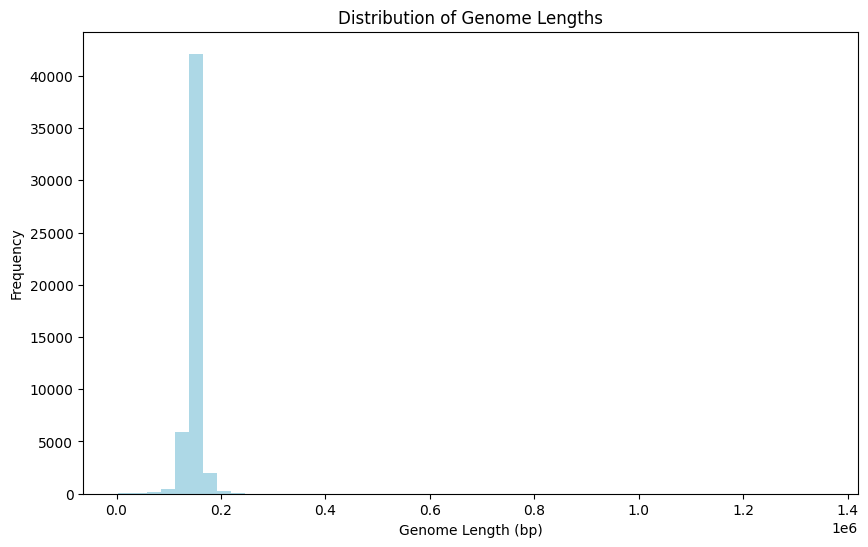

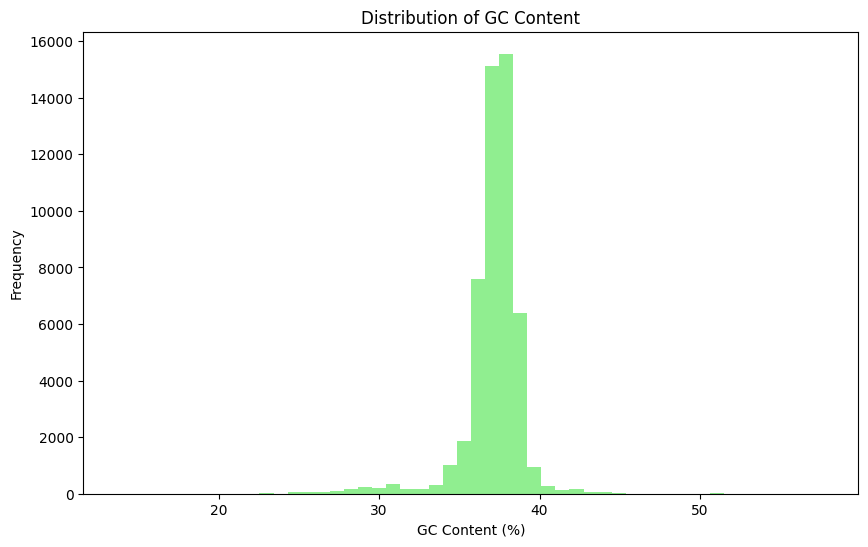

In [8]:
#plot a histogram of genome lengths
plt.figure(figsize=(10, 6))
genome_metadata['Genome_Length'].dropna().plot(kind='hist', bins=50, color='lightblue')
plt.title('Distribution of Genome Lengths')
plt.xlabel('Genome Length (bp)')
plt.ylabel('Frequency')
#plot a histogram of GC content
plt.figure(figsize=(10, 6))
genome_metadata['GC_Content'].dropna().plot(kind='hist', bins=50,
    color='lightgreen')
plt.title('Distribution of GC Content')
plt.xlabel('GC Content (%)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

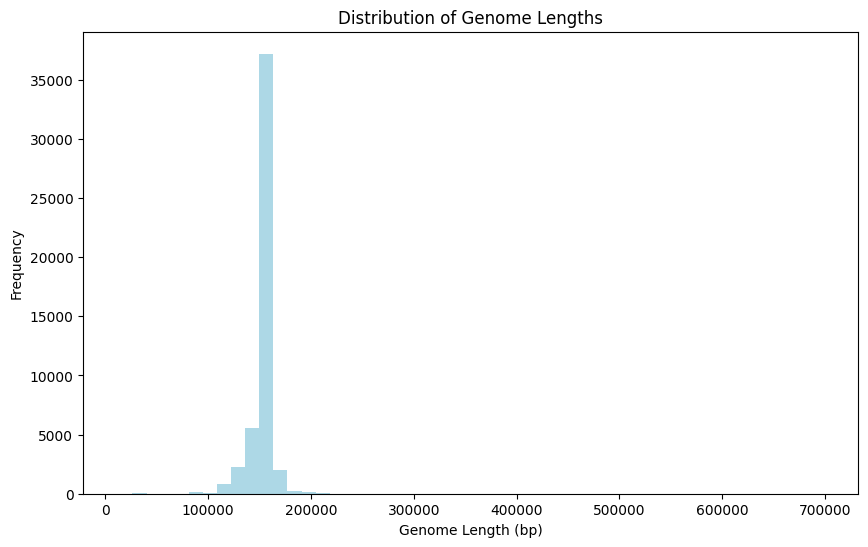

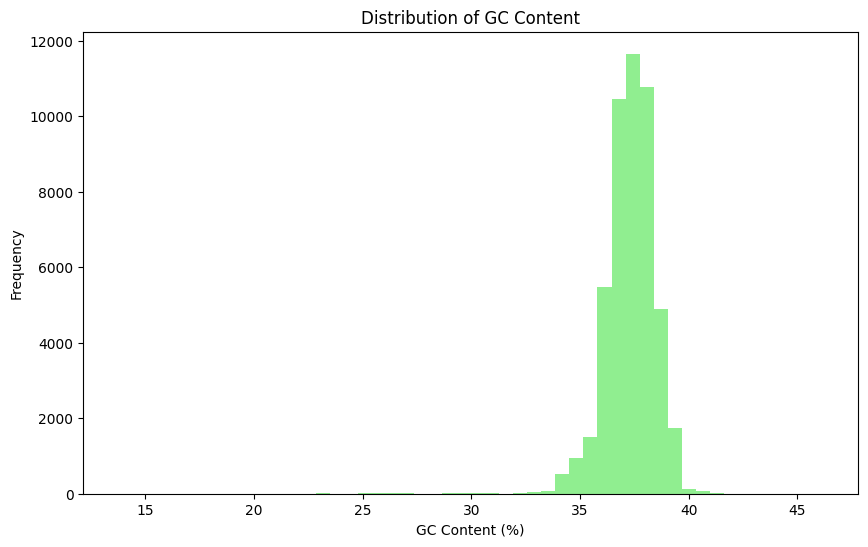

In [5]:
#filter to only include the genomes that have "Spermatophyta" in the taxonomy
plant_genomes = genome_metadata[genome_metadata['Taxonomy'].str.contains('Spermatophyta', na=False)]
#plot a histogram of genome lengths
plt.figure(figsize=(10, 6))
plant_genomes['Genome_Length'].dropna().plot(kind='hist', bins=50, color='lightblue')
plt.title('Distribution of Genome Lengths')
plt.xlabel('Genome Length (bp)')
plt.ylabel('Frequency')
#plot a histogram of GC content
plt.figure(figsize=(10, 6))
plant_genomes['GC_Content'].dropna().plot(kind='hist', bins=50,
    color='lightgreen')
plt.title('Distribution of GC Content')
plt.xlabel('GC Content (%)')
plt.ylabel('Frequency')

Number of genomes with GC content < 30%: 783


Text(0, 0.5, 'Frequency')

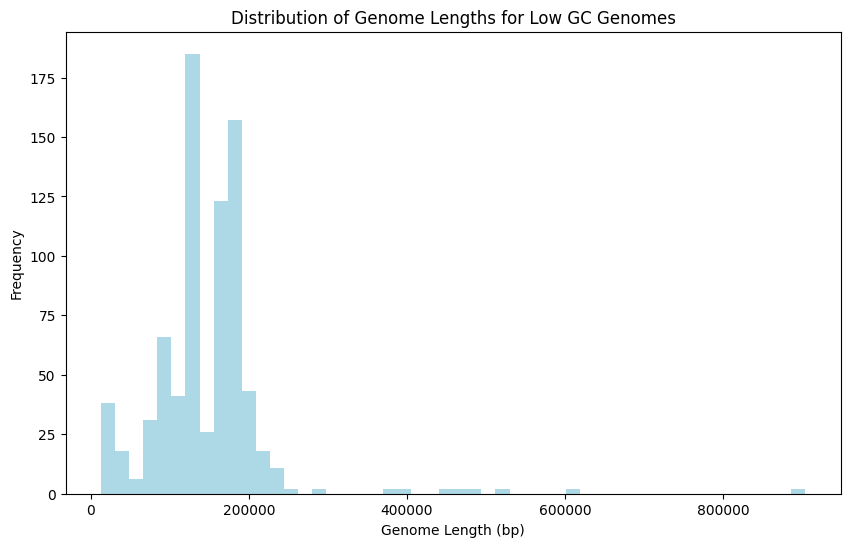

In [10]:
low_gc_genomes = genome_metadata[genome_metadata['GC_Content'] < 30]
print(f"Number of genomes with GC content < 30%: {len(low_gc_genomes)}")
#plot a histogram of genome lengths for low GC genomes
plt.figure(figsize=(10, 6))
low_gc_genomes['Genome_Length'].dropna().plot(kind='hist', bins=50, color='lightblue')
plt.title('Distribution of Genome Lengths for Low GC Genomes')
plt.xlabel('Genome Length (bp)')
plt.ylabel('Frequency') 

Number of filtered plant genomes: 48108


Text(0.5, 1.0, 'Distribution of GC Content for Filtered Plant Genomes')

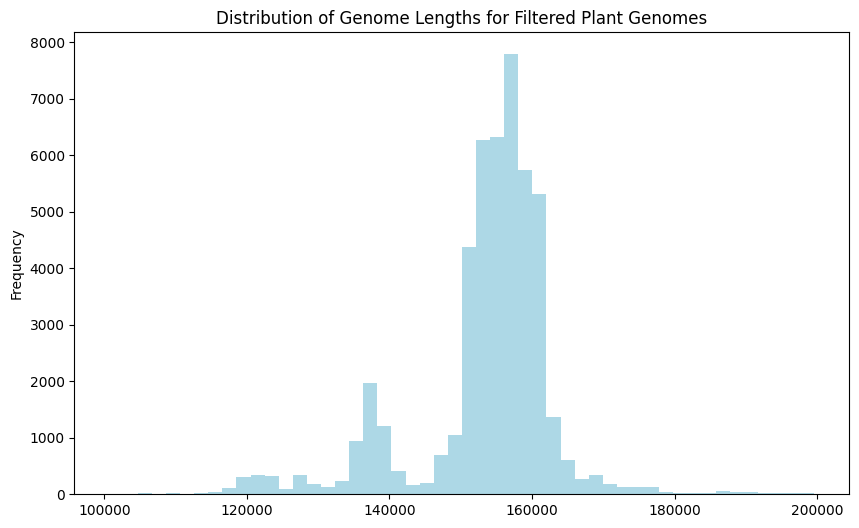

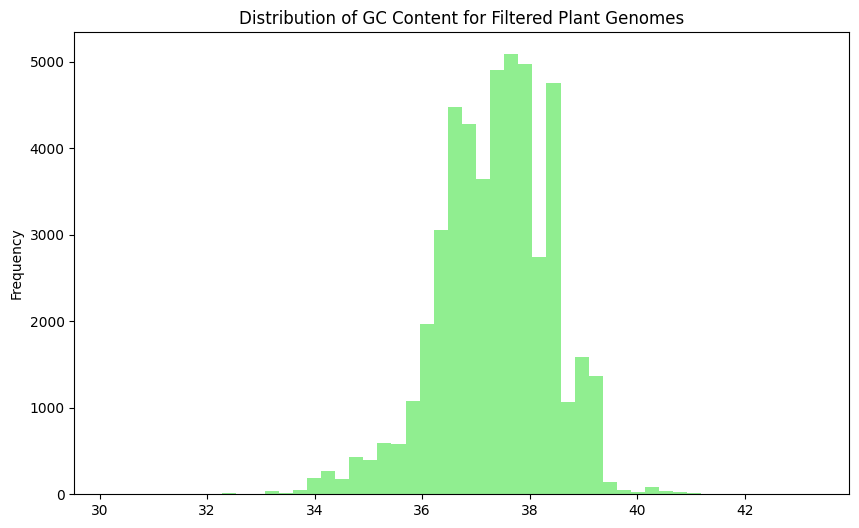

In [6]:
#filtered_plant_genomes = plant genomes with 100000 bp < genome length < 200000 bp and GC content < 30%

filtered_plant_genomes = plant_genomes[(plant_genomes['Genome_Length'] > 100000) & 
                                        (plant_genomes['Genome_Length'] < 200000) & 
                                        (plant_genomes['GC_Content'] > 30)]
print(f"Number of filtered plant genomes: {len(filtered_plant_genomes)}")

#plot the histogram of genome lengths for filtered plant genomes
plt.figure(figsize=(10, 6))
filtered_plant_genomes['Genome_Length'].dropna().plot(kind='hist', bins=50, color='lightblue')
plt.title('Distribution of Genome Lengths for Filtered Plant Genomes')

#plot the histogram of GC content for filtered plant genomes
plt.figure(figsize=(10, 6))
filtered_plant_genomes['GC_Content'].dropna().plot(kind='hist', bins=50, color='lightgreen')
plt.title('Distribution of GC Content for Filtered Plant Genomes')

Number of barley genomes: 1425


Text(0.5, 1.0, 'Distribution of GC Content for Barley Genomes')

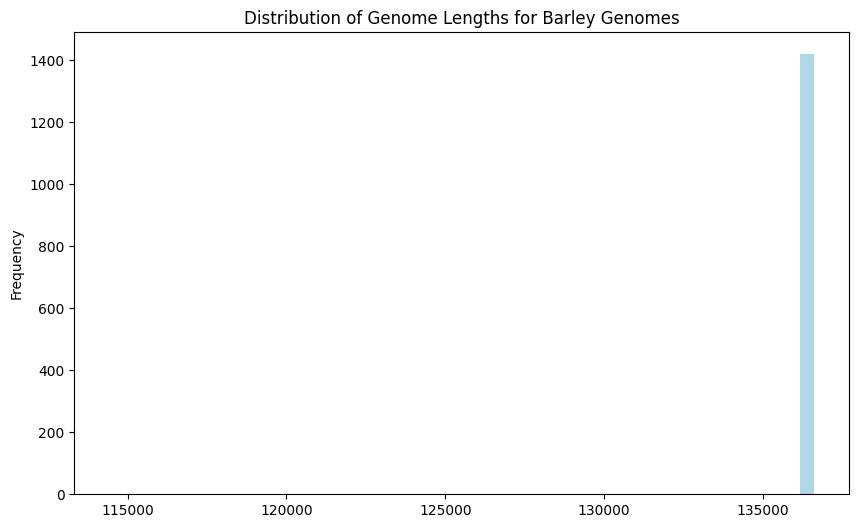

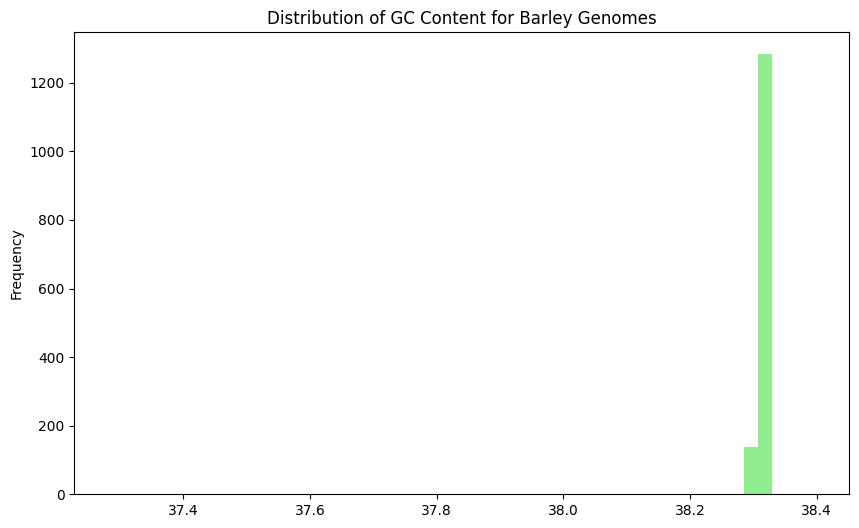

In [14]:
#let's look at barley, which has many genomes, and assess the variation in genome length and GC content
barley_genomes = genome_metadata[genome_metadata['Organism'].str.contains('Hordeum vulgare', na=False)]
print(f"Number of barley genomes: {len(barley_genomes)}")
#plot a histogram of genome lengths for barley genomes
plt.figure(figsize=(10, 6))
barley_genomes['Genome_Length'].dropna().plot(kind='hist', bins=50, color='lightblue')
plt.title('Distribution of Genome Lengths for Barley Genomes')
#plot a histogram of GC content for barley genomes
plt.figure(figsize=(10, 6))
barley_genomes['GC_Content'].dropna().plot(kind='hist', bins=50 , color='lightgreen')
plt.title('Distribution of GC Content for Barley Genomes')

In [7]:
vmatch_dir = "data/vmatch_output/"

def parse_largest_ir(vmatch_file):
    best = None
    with open(vmatch_file) as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            fields = line.strip().split()
            if fields[3] != 'P':
                continue
            length = int(fields[0])
            start = int(fields[2])
            end = int(fields[6])
            identity = float(fields[10])
            if best is None or length > best[0]:
                best = (length, start, end, identity)
    return best

cols = ['Largest_IR_Length', 'IR_Start', 'IR_End', 'IR_Identity']
for col in cols:
    genome_metadata[col] = None

for index, row in tqdm(genome_metadata.iterrows(), total=len(genome_metadata)):
    lui = row['LUI']
    file_path = os.path.join(vmatch_dir, f"{lui}_inverted.txt")
    if os.path.exists(file_path):
        result = parse_largest_ir(file_path)
        if result:
            genome_metadata.at[index, cols[0]] = result[0]
            genome_metadata.at[index, cols[1]] = result[1]
            genome_metadata.at[index, cols[2]] = result[2]
            genome_metadata.at[index, cols[3]] = result[3]


100%|██████████| 53181/53181 [03:30<00:00, 252.86it/s]


Number of genomes without an IR: 4935


Number of genomes without an IR: 3671


Text(0, 0.5, 'Frequency')

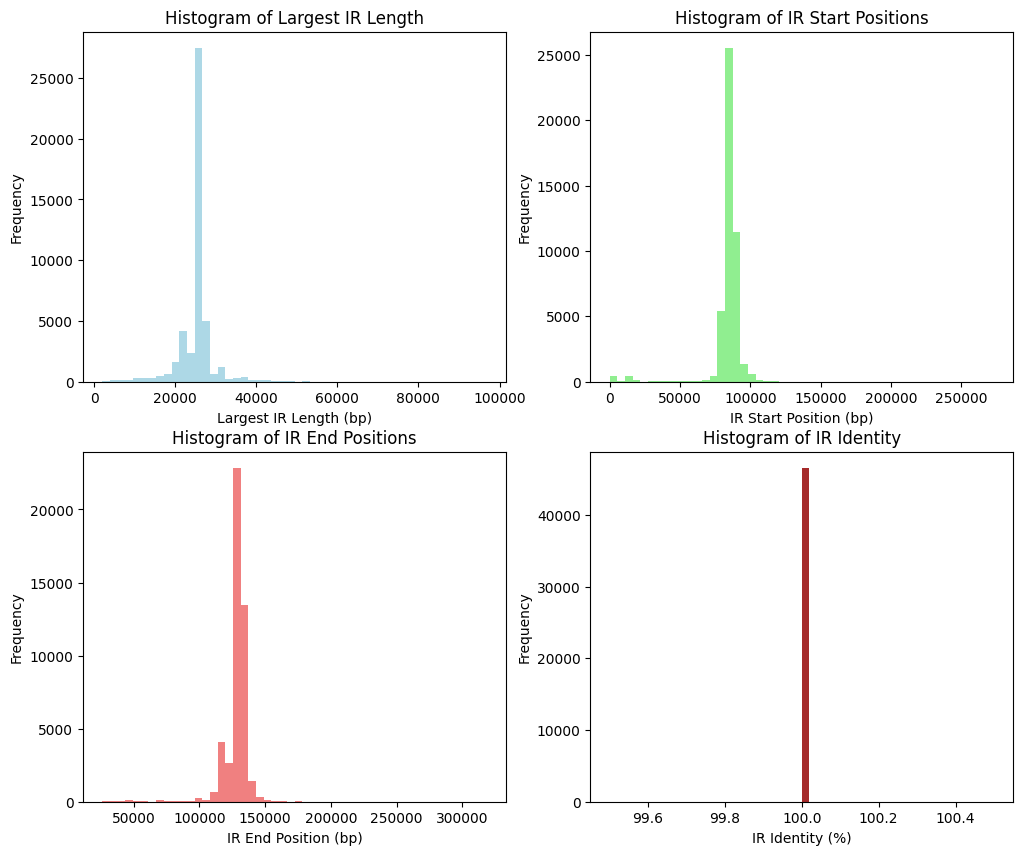

In [8]:
# make a 4 panel figure with the following plots:
# 1. Histogram of Largest IR Length
# 2. Histogram of IR Start positions
# 3. Histogram of IR End positions
# 4. Histogram of IR Identity

plant_genomes = genome_metadata[genome_metadata['Taxonomy'].str.contains('Spermatophyta', na=False)]
#how many genomes did not have an IR?
no_ir_genomes = plant_genomes[plant_genomes['Largest_IR_Length'].isna()]
print(f"Number of genomes without an IR: {len(no_ir_genomes)}")

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].hist(plant_genomes['Largest_IR_Length'].dropna(),
                bins=50, color='lightblue')
axs[0, 0].set_title('Histogram of Largest IR Length')
axs[0, 0].set_xlabel('Largest IR Length (bp)')
axs[0, 0].set_ylabel('Frequency')
axs[0, 1].hist(plant_genomes['IR_Start'].dropna(),
                bins=50, color='lightgreen')
axs[0, 1].set_title('Histogram of IR Start Positions')
axs[0, 1].set_xlabel('IR Start Position (bp)')
axs[0, 1].set_ylabel('Frequency')
axs[1, 0].hist(plant_genomes['IR_End'].dropna(),
                bins=50, color='lightcoral')
axs[1, 0].set_title('Histogram of IR End Positions')
axs[1, 0].set_xlabel('IR End Position (bp)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 1].hist(plant_genomes['IR_Identity'].dropna(),
                bins=50, color='brown')
axs[1, 1].set_title('Histogram of IR Identity')
axs[1, 1].set_xlabel('IR Identity (%)')
axs[1, 1].set_ylabel('Frequency')

In [25]:
#of the no_ir_genomes, how many are contain "Fabaceae" in the taxonomy?
fabaceae_no_ir = no_ir_genomes[no_ir_genomes['Taxonomy'].str.contains('Fabaceae', na=False)]
print(f"Number of Fabaceae genomes without an IR: {len(fabaceae_no_ir)}")


Number of Fabaceae genomes without an IR: 747


In [9]:
#read the environmental data in from "data/geoDataOut/merged_results.csv", merge by LUI, and plot median_Topt_site and median_X4.5 for each LUI
env_data = pd.read_csv("data/geoDataOut/merged_results.csv")
#merge with genome_metadata on LUI
merged_data = pd.merge(genome_metadata, env_data, on='LUI', how='inner')

#how many Na variables are there in the merged data in the Topt_site and X4.5 columns
na_count = merged_data[['Median_Topt_site', 'Median_X4.5']].isna().sum()
print(f"Number of Na values in Median_Topt_site: {na_count['Median_Topt_site']}, Median_X4.5: {na_count['Median_X4.5']}")

#what's the dimensions of the merged data?
print(f"Dimensions of merged data: {merged_data.shape}")

Number of Na values in Median_Topt_site: 0, Median_X4.5: 0
Dimensions of merged data: (16250, 17)


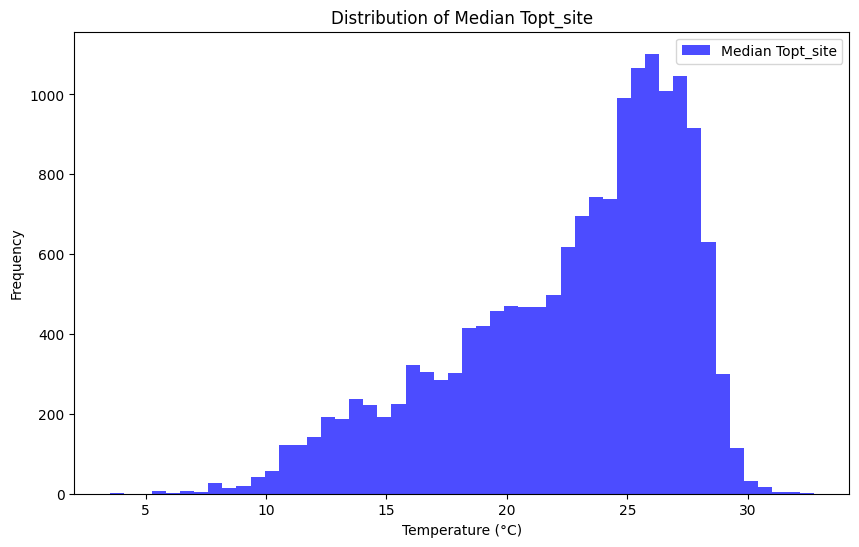

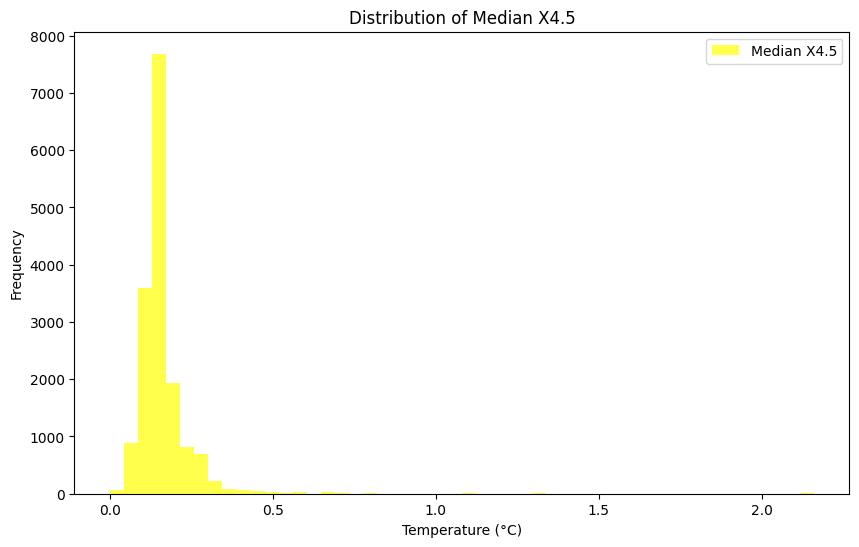

In [30]:
#plot median_Topt_site vs Median_X4.5 histograms
plt.figure(figsize=(10, 6))
plt.hist(merged_data['Median_Topt_site'].dropna(), bins=50, color='blue', alpha=0.7, label='Median Topt_site')
plt.title('Distribution of Median Topt_site')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()

plt.figure(figsize=(10, 6))
plt.hist(merged_data['Median_X4.5'].dropna(), bins=50, color='yellow', alpha=0.7, label='Median X4.5')
plt.title('Distribution of Median X4.5')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()

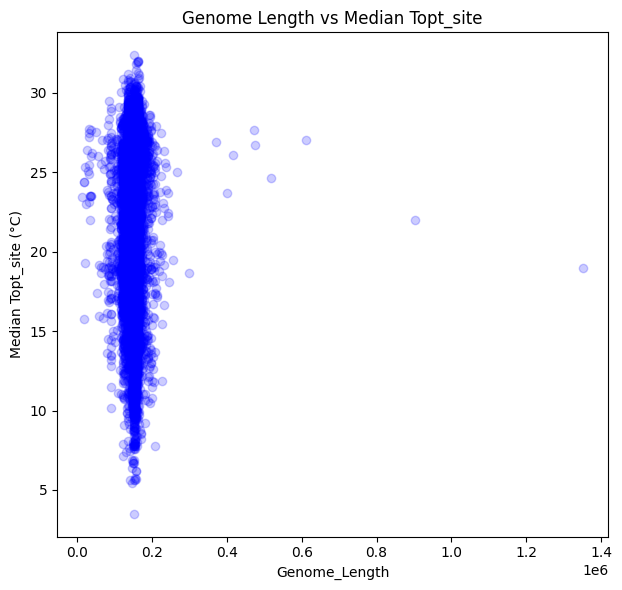

In [35]:
#let's focus on Median_Topt_site; plot the genomic variables against the temp
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(merged_data['Genome_Length'], merged_data['Median_Topt_site'], alpha=0.2, color='blue')
plt.title('Genome Length vs Median Topt_site')
plt.xlabel('Genome_Length')
plt.ylabel('Median Topt_site (°C)')
plt.tight_layout()
plt.show()


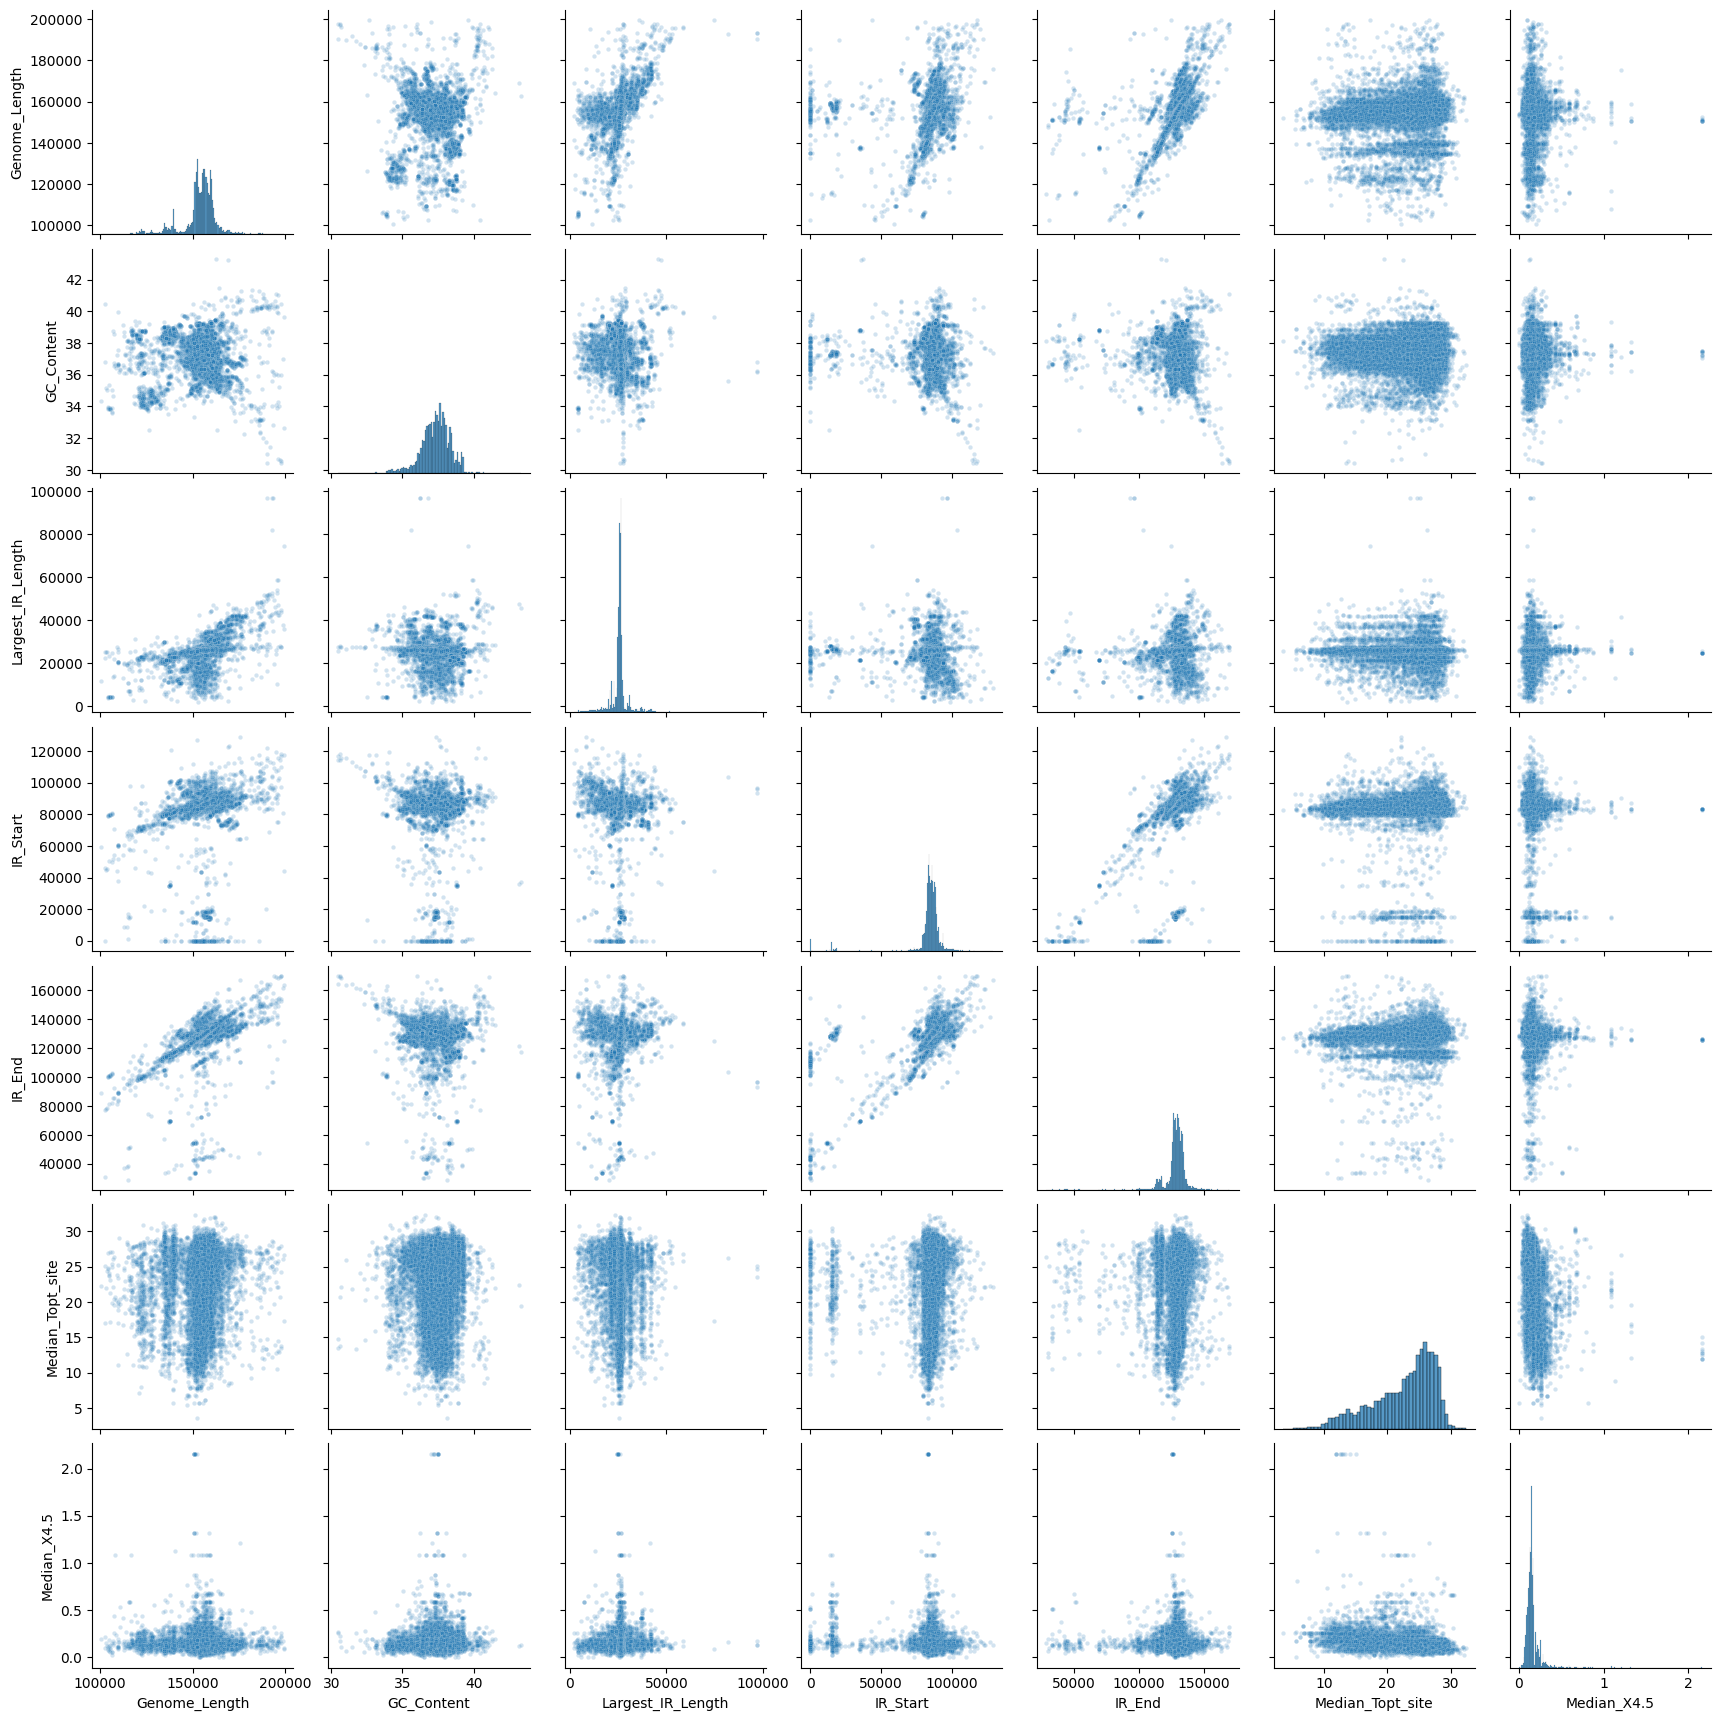

In [10]:
plot_vars = ['Genome_Length', 'GC_Content', 'Largest_IR_Length', 'IR_Start', 'IR_End', 'Median_Topt_site', 'Median_X4.5']

#ensure merged data is filtered on strep
merged_data = merged_data[merged_data['Taxonomy'].str.contains('Spermatophyta', na=False) &
                                        (merged_data['Genome_Length'] > 100000) & 
                                        (merged_data['Genome_Length'] < 200000) & 
                                        (merged_data['GC_Content'] > 30)]


sns.pairplot(merged_data[plot_vars], diag_kind='hist', plot_kws={'alpha':0.2, 's':10})

In [11]:
nitrogen_status = pd.read_csv("data/nitrogen_status.csv")
#what are the dimensions of nitrogen status data?
print(f"Dimensions of nitrogen status data: {nitrogen_status.shape}")
#how many unique LUI are there in nitrogen status data?
print(f"Number of unique LUI in nitrogen status data: {nitrogen_status['LUI'].nunique()}")
#merge with merged_data on LUI
nitro_merged_data = pd.merge(merged_data, nitrogen_status, on='LUI', how='inner')
print(nitro_merged_data.head())
print(f"Dimensions of nitrogen status data: {nitro_merged_data.shape}")

#how many unique species and organisms are there in the merged data?
print(f"Number of unique species in merged data: {nitro_merged_data['Species'].nunique()}")
print(f"Number of unique organisms in merged data: {nitro_merged_data['Organism'].nunique()}")  


Dimensions of nitrogen status data: (11067, 5)
Number of unique LUI in nitrogen status data: 11067
           ID               Organism  \
0  PP697941.1  Lonicera ruprechtiana   
1  PP697910.1       Lonicera hispida   
2  PP697868.1   Lonicera microphylla   
3  PV631714.1  Diospyros cathayensis   
4  PQ301464.1       Carissa carandas   

                                          Taxonomy_x  Year SequencingTech  \
0  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown   
1  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown   
2  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown   
3  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025       Illumina   
4  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025       Illumina   

                             LUI               Species  Genome_File  \
0  PP6979411Loniceraruprechtiana  Loniceraruprechtiana         True   
1       PP6979101Lonicerahispida       Lonicerahispida 

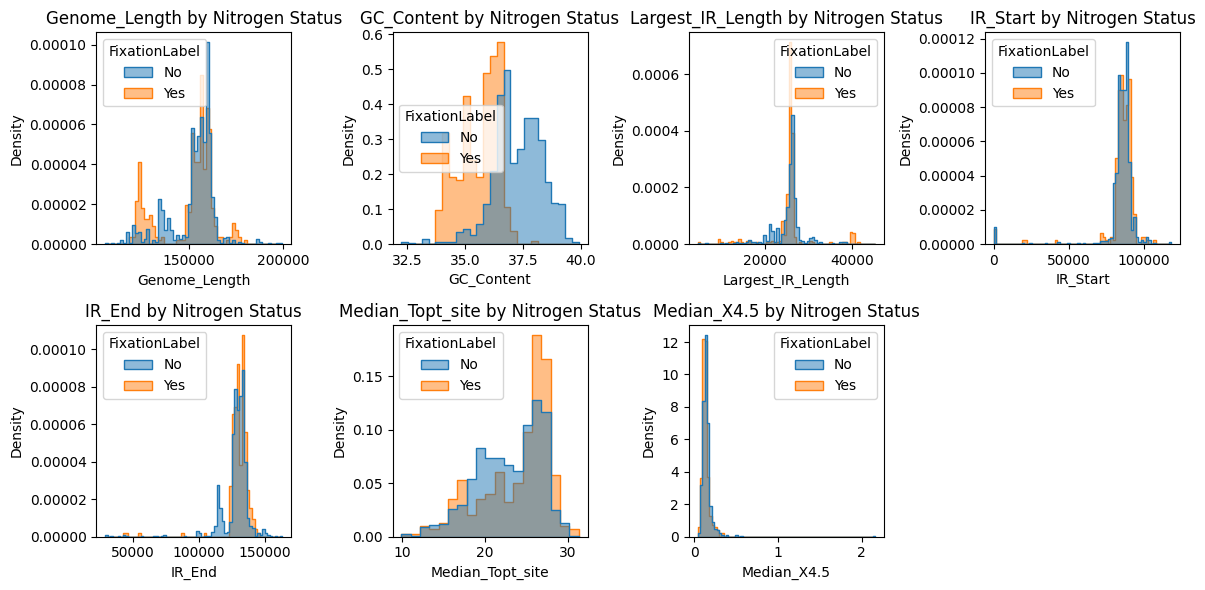

/tmp/ipykernel_574840/808158047.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=nitro_merged_data, x='FixationLabel', order=


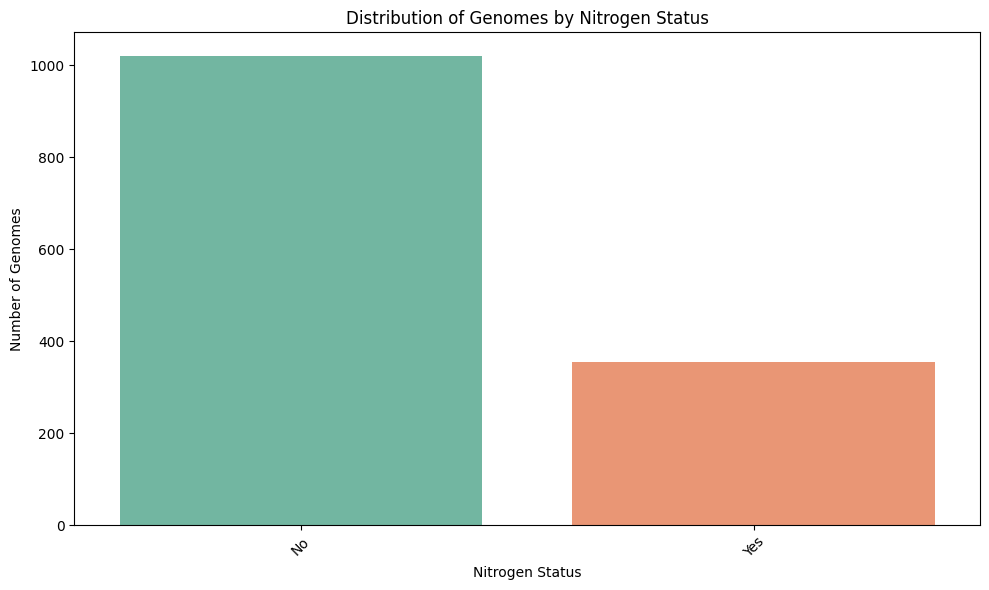

In [48]:
#plot histograms of the quantitative variables in the merged data according to nitrogen status, overlapping the histograms
plt.figure(figsize=(12, 6))
for var in plot_vars:
    plt.subplot(2, 4, plot_vars.index(var) + 1)
    sns.histplot(data=nitro_merged_data, x=var, hue='FixationLabel', element='step', stat='density', common_norm=False, alpha=0.5)
    plt.title(f'{var} by Nitrogen Status')
    plt.xlabel(var)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

#what's the distribution of the number of genomes by nitrogen status?
plt.figure(figsize=(10, 6))
sns.countplot(data=nitro_merged_data, x='FixationLabel', order=
    nitro_merged_data['FixationLabel'].value_counts().index, palette='Set2')
plt.title('Distribution of Genomes by Nitrogen Status')
plt.xlabel('Nitrogen Status')
plt.ylabel('Number of Genomes')
plt.xticks(rotation=45)
plt.tight_layout()

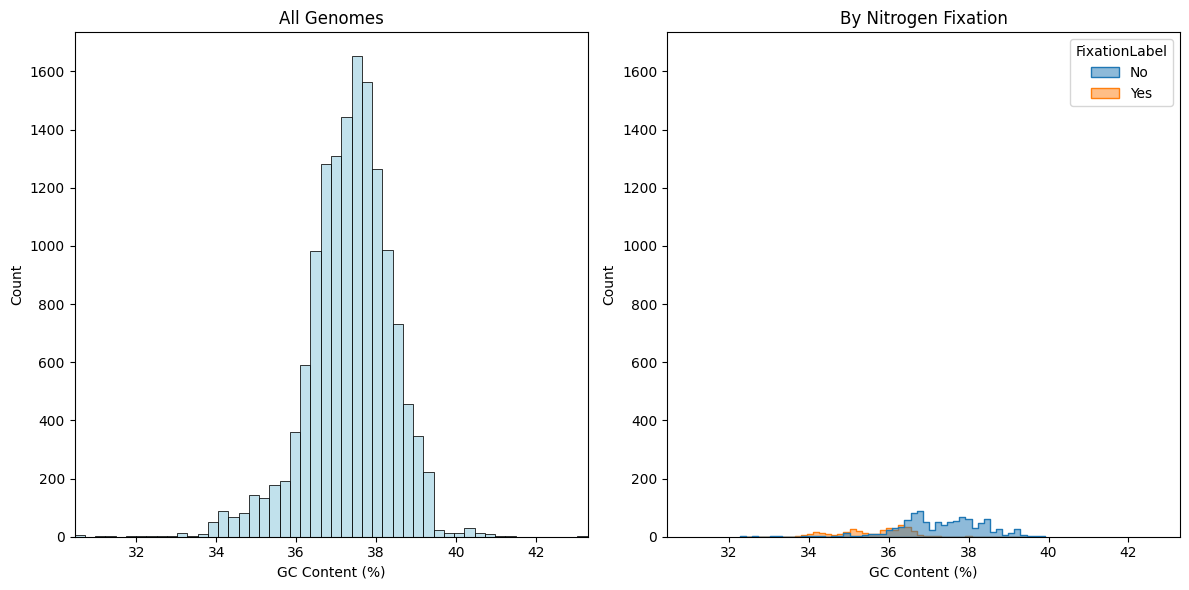

In [53]:
plt.figure(figsize=(12, 6))

bins = 50
xlim = (merged_data['GC_Content'].min(), merged_data['GC_Content'].max())

ax1 = plt.subplot(1, 2, 1)
sns.histplot(data=merged_data, x='GC_Content', bins=bins, color='lightblue', stat='count')
plt.title('All Genomes')
plt.xlabel('GC Content (%)')
plt.ylabel('Count')
plt.xlim(xlim)

ax2 = plt.subplot(1, 2, 2)
sns.histplot(data=nitro_merged_data, x='GC_Content', bins=bins, hue='FixationLabel', element='step', stat='count', common_norm=False, alpha=0.5)
plt.title('By Nitrogen Fixation')
plt.xlabel('GC Content (%)')
plt.ylabel('Count')
plt.xlim(xlim)
ax2.set_ylim(ax1.get_ylim())

plt.tight_layout()
plt.show()


Dimensions of nitrogen merged data: (1375, 21)


/tmp/ipykernel_574840/3819404204.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Nitrogen Status')


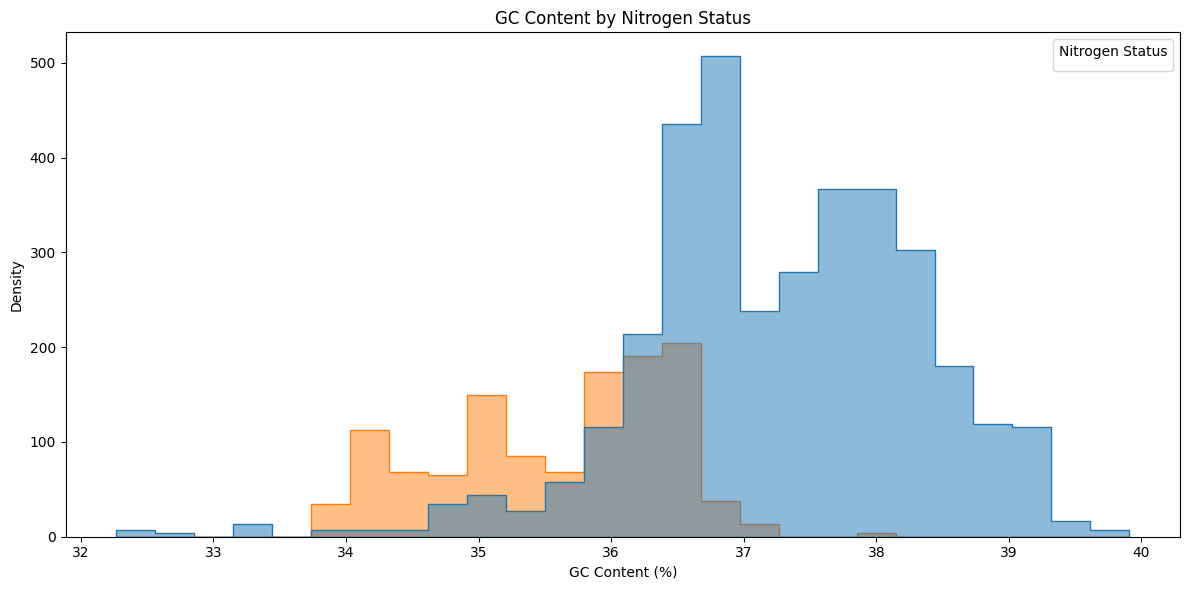

In [68]:
#what are the dimensions of nitrogen merged data?
print(f"Dimensions of nitrogen merged data: {nitro_merged_data.shape}")
#looks like there is a difference, plot the overlappiong histograms of GC content by nitrogen status
plt.figure(figsize=(12, 6))
sns.histplot(
    data=nitro_merged_data,
    x='GC_Content',
    hue='FixationLabel',
    element='step',
    stat='frequency',
    common_norm=False,
    alpha=0.5
)
plt.title('GC Content by Nitrogen Status')
plt.xlabel('GC Content (%)')
plt.ylabel('Frequency')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Nitrogen Status')
plt.tight_layout()


In [ ]:
#run a t-test for GC content between the two nitrogen status groups
from scipy import stats
fixation_groups = nitro_merged_data.groupby('FixationLabel')['GC_Content'].apply(list)
t_stat, p_value = stats.ttest_ind(fixation_groups['No'], fixation_groups['Yes'], equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

#is the difference explicable by the difference in IR length?
from scipy.stats import linregress
#run a linear regression of GC content on IR length, grouped by nitrogen status
fixation_groups = nitro_merged_data.groupby('FixationLabel')
results = []

T-statistic: 29.89128279839206, P-value: 8.029711193616897e-130


AttributeError: 'float' object has no attribute 'shape'

In [17]:
#pathway data is a tsv
phData = pd.read_csv('data/photosynthesisPathways.txt', index_col=0, sep='\t', encoding_errors='replace')
print(phData.shape)

phData = phData[phData["DataName"] == "Plant photosynthetic pathway"]
phData["OrigValueStr"] = phData["OrigValueStr"].replace({
    "c3": "C3", "C3.": "C3", "c4": "C4"
})
clean_phData = phData[phData["OrigValueStr"].isin(["C3", "C4", "CAM"])].copy()

conflicting = (
    clean_phData.groupby("AccSpeciesName")["OrigValueStr"]
    .nunique()
    .reset_index()
    .rename(columns={"OrigValueStr": "n_unique"})
)
conflicting = conflicting[conflicting["n_unique"] > 1]

clean_phData = clean_phData[~clean_phData["AccSpeciesName"].isin(conflicting["AccSpeciesName"])]

toMerge = clean_phData[["AccSpeciesName", "OrigValueStr"]].drop_duplicates()
#rename OrigValueStr to PhotosynthesisType
toMerge = toMerge.rename(columns={"OrigValueStr": "PhotosynthesisType"})

/tmp/ipykernel_883489/2394992138.py:2: DtypeWarning: Columns (15,16,18,19,21,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  phData = pd.read_csv('data/photosynthesisPathways.txt', index_col=0, sep='\t', encoding_errors='replace')


(2236552, 28)


In [21]:
#merge toMerge on AccSpeciesName with merged_data on Organism
ph_merged_data = merged_data.merge(toMerge, left_on='Organism', right_on='AccSpeciesName', how='left')
#print some summary of the merged data
print(f"Dimensions of photosynthesis merged data: {ph_merged_data.shape}")
print(f"Number of unique species in photosynthesis merged data: {ph_merged_data['Species'].nunique()}")
print(f"Number of unique organisms in photosynthesis merged data: {ph_merged_data['Organism'].nunique()}")
#how many NA values are there in the PhotosynthesisType column?
na_count = ph_merged_data['PhotosynthesisType'].isna().sum()
print(f"Number of NA values in PhotosynthesisType: {na_count}")
#drop NA values in PhotosynthesisType
ph_merged_data = ph_merged_data.dropna(subset=['PhotosynthesisType'])

Dimensions of photosynthesis merged data: (14281, 19)
Number of unique species in photosynthesis merged data: 13649
Number of unique organisms in photosynthesis merged data: 14281
Number of NA values in PhotosynthesisType: 10861


/tmp/ipykernel_883489/1096162942.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ph_merged_data, x='PhotosynthesisType', order=


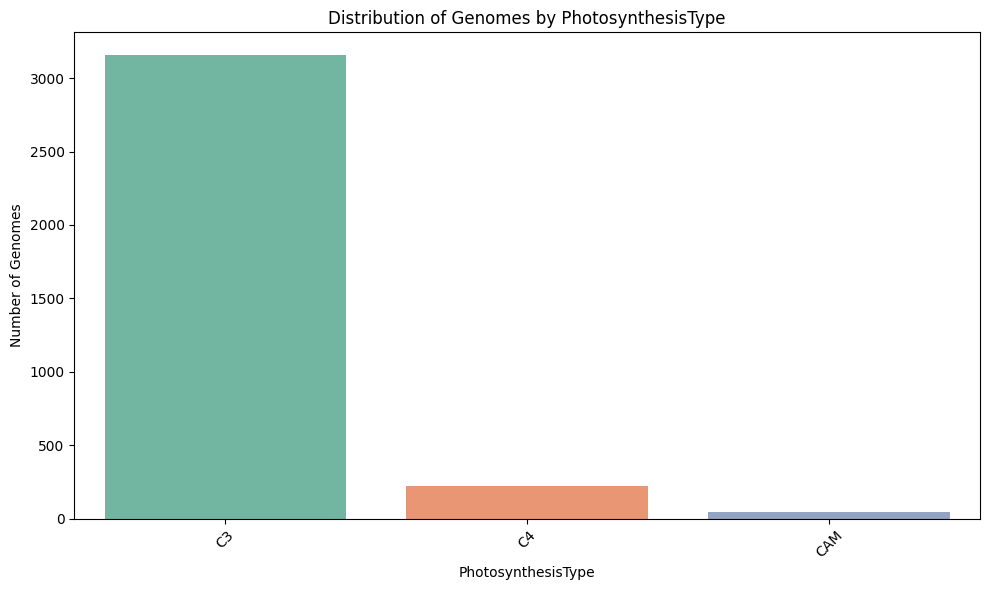

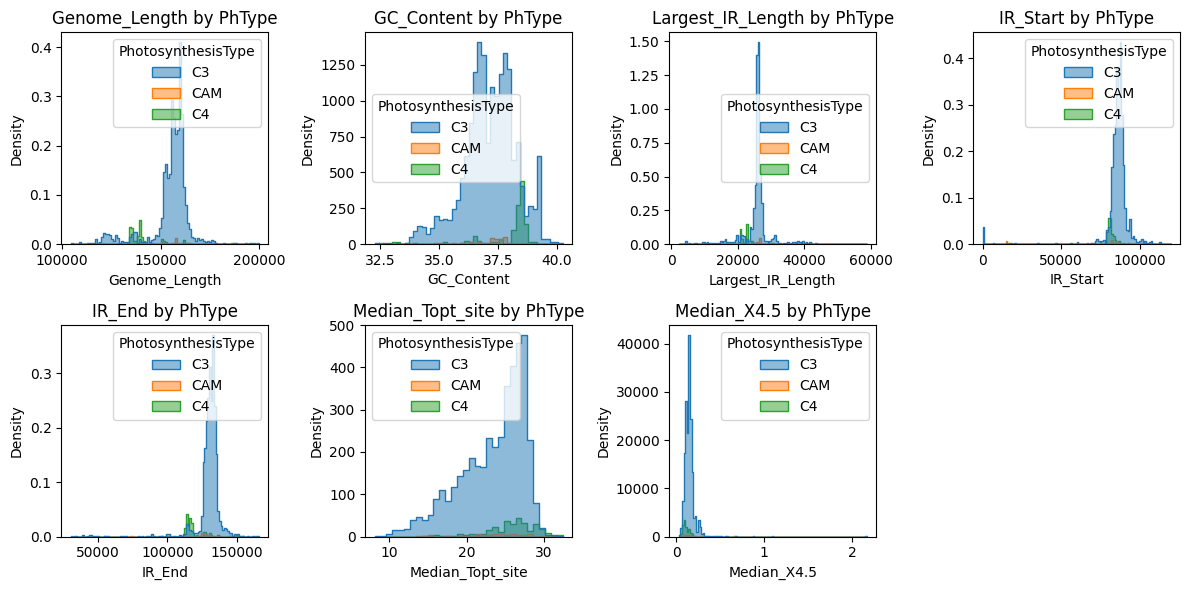

In [ ]:
#what's the distribution of the number of genomes by nitrogen status?
plt.figure(figsize=(10, 6))
sns.countplot(data=ph_merged_data, x='PhotosynthesisType', order=
    ph_merged_data['PhotosynthesisType'].value_counts().index, palette='Set2')
plt.title('Distribution of Genomes by PhotosynthesisType')
plt.xlabel('PhotosynthesisType')
plt.ylabel('Number of Genomes')
plt.xticks(rotation=45)
plt.tight_layout()

#plot histograms of the quantitative variables in the merged data according to nitrogen status, overlapping the histograms
plt.figure(figsize=(12, 6))
for var in plot_vars:
    plt.subplot(2, 4, plot_vars.index(var) + 1)
    sns.histplot(data=ph_merged_data, x=var, hue='PhotosynthesisType', element='step', stat='frequency', common_norm=False, alpha=0.5)
    plt.title(f'{var} by PhType')
    plt.xlabel(var)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

/tmp/ipykernel_883489/2297349783.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Photosynthesis Type', title_fontsize='medium', fontsize='small')


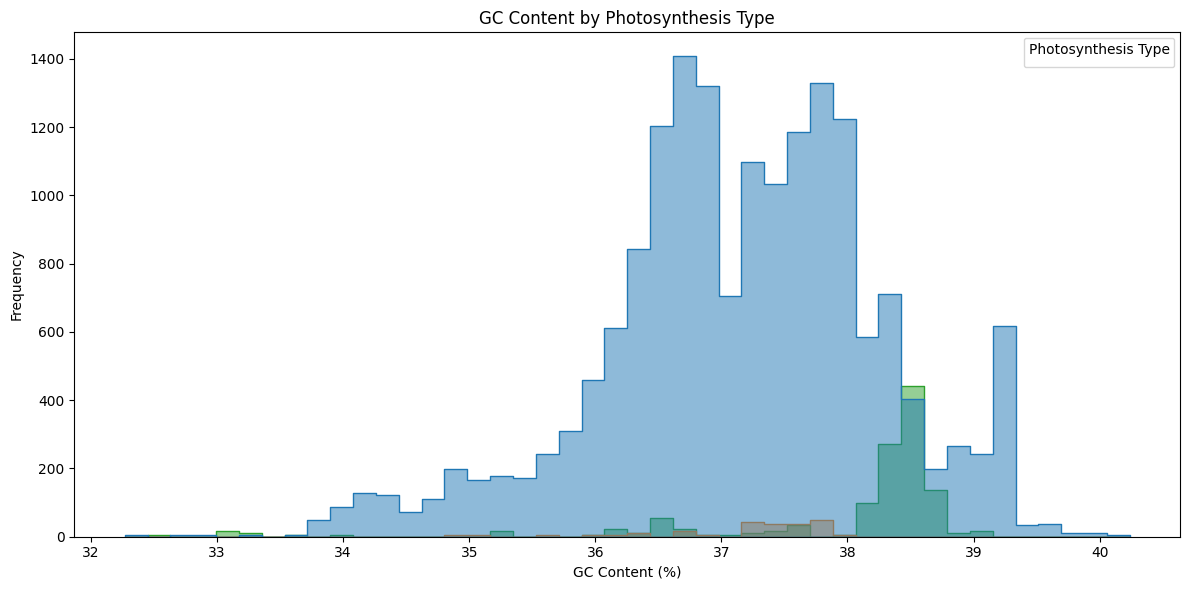

In [25]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=ph_merged_data,
    x='GC_Content',
    hue='PhotosynthesisType',
    element='step',
    stat='frequency',
    common_norm=False,
    alpha=0.5
)
plt.title('GC Content by Photosynthesis Type')
plt.xlabel('GC Content (%)')
plt.ylabel('Frequency')
plt.legend(title='Photosynthesis Type', title_fontsize='medium', fontsize='small')
plt.tight_layout()


<function matplotlib.pyplot.show(close=None, block=None)>

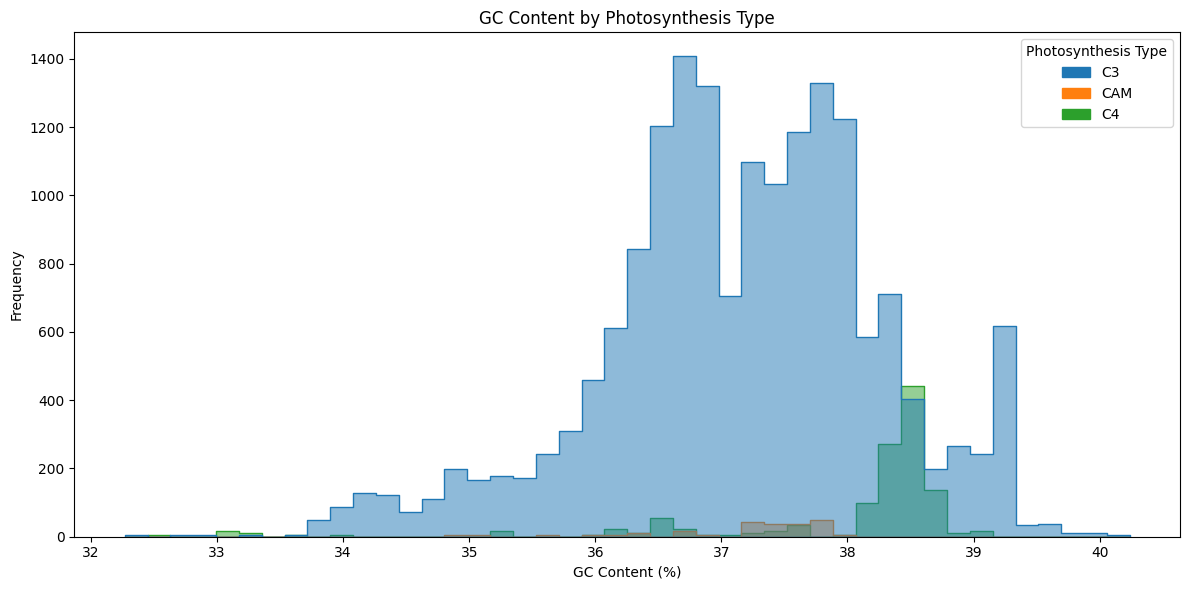

In [29]:
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 6))

# Ensure PhotosynthesisType is string for clarity
ph_merged_data['PhotosynthesisType'] = ph_merged_data['PhotosynthesisType'].astype(str)

# Plot
sns.histplot(
    data=ph_merged_data,
    x='GC_Content',
    hue='PhotosynthesisType',
    element='step',
    stat='frequency',
    common_norm=False,
    alpha=0.5
)

# Manually build legend
unique_types = ph_merged_data['PhotosynthesisType'].dropna().unique()
colors = sns.color_palette(n_colors=len(unique_types))
handles = [mpatches.Patch(color=c, label=t) for c, t in zip(colors, unique_types)]

plt.legend(handles=handles, title='Photosynthesis Type')
plt.title('GC Content by Photosynthesis Type')
plt.xlabel('GC Content (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show

